トレーニング: 不動産価格予想

In [25]:
DIR_PATH = "/cpt_training"

In [26]:
cd {DIR_PATH}

[Errno 2] No such file or directory: '/cpt_training'
/Users/otake_toya/Documents/Develop/cpt_training


/Users/otake_toya/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [27]:
%pip install -U "setuptools<58" # setuptoolsのverが58以上だと、xfeatの依存パッケージml-metricsのinstallに失敗するため
%pip install -q optuna xfeat japanize-matplotlib
%pip install -q optuna

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [28]:
# import
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer
# パラメータチューニングで必要なライブラリ
import optuna
from sklearn.metrics import mean_absolute_error

In [29]:
pd.set_option('display.max_columns', None)

In [30]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
time_col = '取引時点_enc'
group_col = '都道府県名'

In [31]:
BASE_PATH = './'

In [32]:
paths = glob(BASE_PATH + 'input/train/*.csv')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'input/test.csv')

# train_df, test_df, val_dfをくっつける
master_df = pd.concat([train_df, test_df])
master_df.sort_values('取引時点', inplace=True)
master_df.reset_index(drop=True, inplace=True)

/var/folders/m_/61qs__1j74v49c64jdk8bz840000gp/T/ipykernel_1355/2232468179.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
/var/folders/m_/61qs__1j74v49c64jdk8bz840000gp/T/ipykernel_1355/2232468179.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)


In [34]:
master_df.columns

Index(['ID', '種類', '地域', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '最寄駅：距離（分）', '間取り', '面積（㎡）', '土地の形状', '間口', '延床面積（㎡）', '建築年', '建物の構造',
       '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装', '取引の事情等', '取引価格（総額）_log'],
      dtype='object')

In [35]:
set(test_df['取引時点'])

{'2020年第１四半期', '2020年第２四半期'}

In [36]:
sub_df = pd.read_csv(BASE_PATH + 'input/sample_submission.csv')

In [37]:
master_df.shape

(656817, 28)

In [38]:
class Preprocessor:
    TARGET = TARGET
    group_col = group_col
    time_col = time_col

    def __init__(self, df):
        self.df = df.copy()
        self.agg_dfs = []
        self.labeling()

    @staticmethod
    def normalize_moyori(moyori):
        if moyori == moyori:
            if moyori == '30分?60分':
                moyori = 45
            elif moyori == '1H?1H30':
                moyori = 75
            elif moyori == '1H30?2H':
                moyori = 105
            elif moyori == '2H?':
                moyori = 120
            moyori = int(float(moyori))
        return moyori

    @staticmethod
    def normalize_area(area):
        if area == area:
            area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
        return area

    @staticmethod
    def convert_wareki_to_seireki(wareki):
        if wareki == wareki:
            if wareki == '戦前':
                wareki = '昭和20年'
            value = wareki[2:-1]
            if value == '元':
                value = 1
            else:
                value = int(value)
            if '昭和' in wareki:
                seireki = 1925+value
            elif '平成' in wareki:
                seireki = 1988+value
            elif '令和' in wareki:
                seireki = 2018+value
        else:
            seireki = wareki
        return seireki

    @staticmethod
    def allocate(data):
        if pd.isna(data) or data == "":
            return 0
        else:
            if 'LDK' in data:
                return 1
            elif 'DK' in data:
                return 2
            elif 'K' in data:
                return 3
            elif 'フリースペース' in data:
                return 4
            else:
                return 5

    @staticmethod
    def extract_room_count(s):
        if pd.isna(s) or s == '':
            return 0
        numbers = re.findall(r'\d+', s)
        return int(numbers[0]) if numbers else 0

    def name_to_number(self):
        """取引時点を数字に変更する関数"""
        enc_dic = {}
        for i, e in enumerate(sorted(list(set(self.df['取引時点'].values)))):
            enc_dic[e] = i
        self.df['取引時点_enc'] = self.df['取引時点'].map(enc_dic)
        return self.df

    def remove_data(self):
        """全て同じ値になっていたり、すべてnullになっているものは削除する!"""
        rm_cols = [col for col in self.df.columns if self.df[col].nunique() <= 1]
        self.df.drop(columns=rm_cols, inplace=True)
        self.df.dropna(axis=1, how='all')

    def calc_mean_target(self):
        """各取引時点,都道府県での各都道府県のTARGETの平均値"""
        @staticmethod
        def calc_te(row):
            if row[self.time_col] in te_dic and row[self.group_col] in te_dic[row[self.time_col]]:
                try:
                    value = te_dic[row[self.time_col]-2][row[self.group_col]]
                except IndexError as e:
                    value = 0
                return value
            else:
                return 0
        te_dic = {}
        for i in set(self.df[self.time_col].values):
            tmp_df = self.df[self.df[self.time_col] < i]
            te_dic[i] = tmp_df.groupby(self.group_col)[TARGET].agg('mean').to_dict()
        # 最後にdfにapplyする
        self.df[self.group_col + '_te'] = self.df.apply(self.calc_te, axis=1)
        return self.df

    def get_agg_df(self):
        """group_valuesそれぞれのagg_methosを計算してくれるやつ"""
        agg_df, agg_cols = aggregation(self.df,
                            group_key=self.group_col,
                            group_values=['最寄駅：距離（分）', '容積率（％）'],
                            agg_methods=['count', 'mean', 'min', 'max'],
                            )
        return agg_df[agg_cols]

    def labeling(self):
        """データを切り取って渡してくれる"""
        self.df.sort_values('取引時点', inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        self.df.loc[self.df['取引時点'].str.contains('2019年第３四半期|2019年第４四半期', regex=True), 'label'] = 1
        self.df.loc[self.df['取引時点'].str.contains('2020年第１四半期|2020年第２四半期', regex=True), 'label'] = 2
        self.df.loc[self.df['label'].isnull(), 'label'] = 0
        # self.feat_cols = [col for col in self.df.columns if col not in rm_cols+[ID, TARGET]]
        # self.df.dropna(how='any', axis=0)

    @staticmethod
    def checkStringExistence(input='', word=''):
        if not isinstance(input, str):
            return 0
        
        if word in input:
            return 1
        else:
            return 0
        
    def dummy(self, dummy_column):
        df_dummies = pd.get_dummies(self.df[dummy_column], prefix=dummy_column, drop_first=True)
        self.df = pd.concat([self.df, df_dummies], axis=1)
        self.df.drop(columns=dummy_column)

    def fit(self):
        self.remove_data()
        self.df['取引時点_何年前'] = self.df['取引時点'].apply(lambda x: 2020-int(x[:4]))
        self.name_to_number()
        # self.df.drop(columns=['取引時点'], axis=1, inplace=True)
        self.df['部屋数'] = self.df['間取り'].apply(self.extract_room_count)
        self.df['部屋タイプ'] = self.df['間取り'].apply(lambda x: self.allocate(x))
        self.df['建築年'] = self.df['建築年'].apply(lambda x: self.convert_wareki_to_seireki(x))
        self.df['面積（㎡）'] = self.df['面積（㎡）'].apply(lambda x: self.normalize_area(x))
        self.df['最寄駅：距離（分）'] = self.df['最寄駅：距離（分）'].apply(lambda x: self.normalize_moyori(x))
        self.df['心理的瑕疵の有無'] = self.df['取引の事情等'].apply(lambda input: self.checkStringExistence(input, '瑕疵有りの可能性')) # "瑕疵有りの可能性"を別のカラムに追加、次のコードで別の列から削除
        self.df['取引の事情等'].replace({'調停・競売等、瑕疵有りの可能性': '調停・競売等',
                                   '関係者間取引、瑕疵有りの可能性': '関係者間取引',
                                   '瑕疵有りの可能性': np.nan}, inplace=True)
        self.dummy('都市計画')
        self.df['建築年'] = np.log(self.df['建築年']) # 建築年の対数変換

    def transform(self):
        num_df = SelectNumerical().fit_transform(self.df)
        encoder = Pipeline([
            SelectCategorical(),
            LabelEncoder(output_suffix=""),
            ])
        le_df = encoder.fit_transform(self.df)
        self.agg_dfs.append(self.get_agg_df())
        self.preprocessed_df = pd.concat([num_df,le_df]+self.agg_dfs, axis=1)
        return self.preprocessed_df

In [41]:
# master_dfを処理していく
processor = Preprocessor(master_df)
processor.fit()
preprocessed_df = processor.transform()



In [44]:
preprocessed_df.columns

Index(['ID', '市区町村コード', '最寄駅：距離（分）', '面積（㎡）', '建築年', '建ぺい率（％）', '容積率（％）',
       '取引価格（総額）_log', 'label', '取引時点_何年前', '取引時点_enc', '部屋数', '部屋タイプ',
       '心理的瑕疵の有無', '都市計画_工業地域', '都市計画_工業専用地域', '都市計画_市街化区域及び市街化調整区域外の都市計画区域',
       '都市計画_市街化調整区域', '都市計画_準住居地域', '都市計画_準工業地域', '都市計画_準都市計画区域',
       '都市計画_第１種中高層住居専用地域', '都市計画_第１種低層住居専用地域', '都市計画_第１種住居地域',
       '都市計画_第２種中高層住居専用地域', '都市計画_第２種低層住居専用地域', '都市計画_第２種住居地域', '都市計画_近隣商業地域',
       '都市計画_都市計画区域外', '都道府県名', '市区町村名', '地区名', '最寄駅：名称', '間取り', '建物の構造', '用途',
       '今後の利用目的', '都市計画', '取引時点', '改装', '取引の事情等',
       'agg_count_最寄駅：距離（分）_grpby_都道府県名', 'agg_count_容積率（％）_grpby_都道府県名',
       'agg_mean_最寄駅：距離（分）_grpby_都道府県名', 'agg_mean_容積率（％）_grpby_都道府県名',
       'agg_min_最寄駅：距離（分）_grpby_都道府県名', 'agg_min_容積率（％）_grpby_都道府県名',
       'agg_max_最寄駅：距離（分）_grpby_都道府県名', 'agg_max_容積率（％）_grpby_都道府県名'],
      dtype='object')

In [45]:
preprocessed_df.drop(columns='都市計画', inplace=True)

In [46]:
# データの割り振り
train_df = preprocessed_df.loc[preprocessed_df['label']==0, :]
train_x = train_df.drop(columns=['label', TARGET])
# train_x.dropna(how='any', axis=0)
train_y = train_df[TARGET]

# データの割り振り
val_df = preprocessed_df.loc[preprocessed_df['label']==1, :]
val_x = val_df.drop(columns=['label', TARGET])
# val_x.dropna(how='any', axis=0)
val_y = val_df[TARGET]

# データの割り振り
test_df = preprocessed_df.loc[preprocessed_df['label']==2, :]
test_x = test_df.drop(columns=['label', TARGET])
# test_x.dropna(how='any', axis=0)
test_y = test_df[TARGET]

In [68]:
train_df

,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,label,取引時点_何年前,取引時点_enc,部屋数,部屋タイプ,心理的瑕疵の有無,都市計画_工業地域,都市計画_工業専用地域,都市計画_市街化区域及び市街化調整区域外の都市計画区域,都市計画_市街化調整区域,都市計画_準住居地域,都市計画_準工業地域,都市計画_準都市計画区域,都市計画_第１種中高層住居専用地域,都市計画_第１種低層住居専用地域,都市計画_第１種住居地域,都市計画_第２種中高層住居専用地域,都市計画_第２種低層住居専用地域,都市計画_第２種住居地域,都市計画_近隣商業地域,都市計画_都市計画区域外,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,取引の事情等,agg_count_最寄駅：距離（分）_grpby_都道府県名,agg_count_容積率（％）_grpby_都道府県名,agg_mean_最寄駅：距離（分）_grpby_都道府県名,agg_mean_容積率（％）_grpby_都道府県名,agg_min_最寄駅：距離（分）_grpby_都道府県名,agg_min_容積率（％）_grpby_都道府県名,agg_max_最寄駅：距離（分）_grpby_都道府県名,agg_max_容積率（％）_grpby_都道府県名
0,13117957,13104,NaN,20,2005.0,80.0,600.0,7.342423,0.0,15,0,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,-1,0,0,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
1,13322502,13116,10.0,20,1992.0,80.0,400.0,7.041393,0.0,15,0,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0,1,1,1,0,0,0,-1,1,0,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
2,13247229,13112,7.0,90,1971.0,60.0,200.0,7.623249,0.0,15,0,2,5,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0,2,2,2,1,0,0,-1,2,0,-1,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
3,13279951,13113,6.0,25,1982.0,80.0,800.0,7.146128,0.0,15,0,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,3,3,3,0,0,0,-1,0,0,1,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
4,26076250,26109,8.0,50,1986.0,80.0,300.0,6.732394,0.0,15,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1,4,4,4,-1,1,0,-1,1,0,0,-1,15009,15380,10.108735,327.955137,0.0,60.0,120.0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612438,13015116,13104,7.0,20,2004.0,60.0,200.0,7.342423,0.0,1,55,1,5,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0,0,975,576,0,1,0,0,4,55,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
612439,13103166,13115,2.0,15,1987.0,80.0,500.0,7.113943,0.0,1,55,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,18,90,85,0,0,0,0,0,55,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
612440,27033427,27128,2.0,25,1998.0,80.0,600.0,7.000000,0.0,1,55,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4,28,826,128,0,1,0,0,0,55,0,-1,72444,73162,9.253244,332.444712,0.0,80.0,120.0,1300.0
612441,13083093,13113,8.0,45,2011.0,60.0,300.0,7.672098,0.0,1,55,2,5,0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0,3,355,299,5,1,-1,0,3,55,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0


モデル構築

In [47]:
train_set = lgb.Dataset(train_x, label=train_y)
val_set = lgb.Dataset(val_x, label=val_y)

In [48]:
def objective(trial):
  params = {
      "objective": "regression",
      "metric": "mae",
      "boosting_type": "gbdt",
      "verbosity": -1,
      "boost_from_average": "false",
      "random_seed": 42,
      "feature_pre_filter": False,
      "max_depth": trial.suggest_int('max_depth', 4, 8),
      "num_leaves": trial.suggest_int("num_leaves", 2, 100),
      "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
      "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
      "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
      "min_child_samples": trial.suggest_int("min_child_samples", 1, 25),
      "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 4)
      }

  model = lgb.train(params, train_set, valid_sets=[val_set])

  pred_y = model.predict(val_x, num_iteration=model.best_iteration)
  mae = mean_absolute_error(val_y, pred_y)

  return mae

In [49]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2024-01-23 18:53:29,060] A new study created in memory with name: no-name-eee050bc-9c50-4a3f-ba41-f65a926c84b1


[I 2024-01-23 18:53:32,165] Trial 0 finished with value: 1.5142865274191806 and parameters: {'max_depth': 7, 'num_leaves': 91, 'learning_rate': 0.01576501045745842, 'feature_fraction': 0.4070091400287934, 'bagging_fraction': 0.6574996465417097, 'min_child_samples': 20, 'min_data_in_leaf': 2}. Best is trial 0 with value: 1.5142865274191806.
[I 2024-01-23 18:53:33,272] Trial 1 finished with value: 0.12478988314772922 and parameters: {'max_depth': 5, 'num_leaves': 62, 'learning_rate': 0.09753941656083619, 'feature_fraction': 0.13962930141688948, 'bagging_fraction': 0.8765746977553587, 'min_child_samples': 20, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.12478988314772922.
[I 2024-01-23 18:53:35,112] Trial 2 finished with value: 0.1323739409973876 and parameters: {'max_depth': 8, 'num_leaves': 48, 'learning_rate': 0.04933320711821122, 'feature_fraction': 0.32749171401046806, 'bagging_fraction': 0.73889590750729, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 1 with 

In [50]:
best_params = study.best_params
# 最適モデルで再度トレーニング
model = lgb.train(best_params, train_set, valid_sets=[val_set]) # early_stopping_roundsは使えなくなったそう。

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=3 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=3 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=3 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1979
[LightGBM] [Info] Number of data points in the train set: 612443, number of used features: 46
[LightGBM] [Info] Start training from score 7.214606


In [51]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)

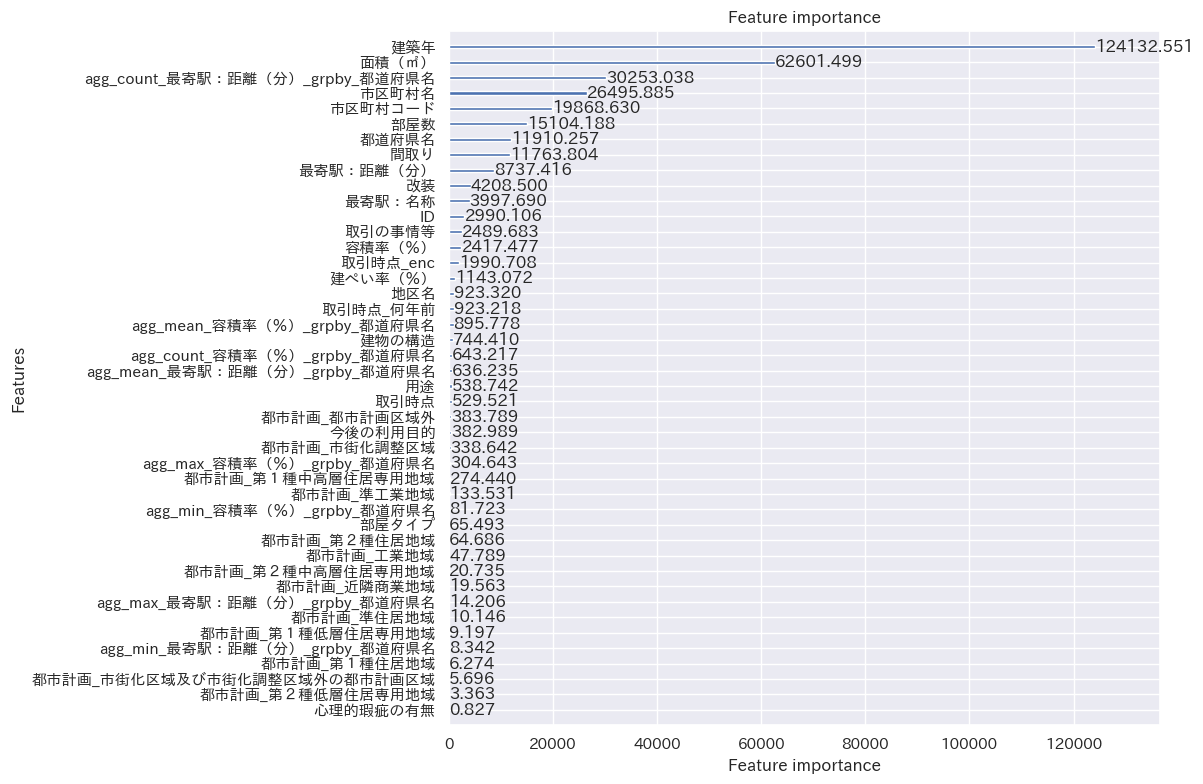

In [52]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(BASE_PATH + 'output/feature_importance.png')
plt.show()
plt.close()

In [53]:
test_df[TARGET] = test_pred

/var/folders/m_/61qs__1j74v49c64jdk8bz840000gp/T/ipykernel_1355/88504142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[TARGET] = test_pred


In [54]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(BASE_PATH + 'output/test_submission_dummy.csv', index=False)